# Monte Carlo Analysis on oil prices keeping supply demand balance with    Periodic Review 

Initialize Libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [2]:
summary = pd.read_csv('summary.csv')
df = pd.read_excel('data.xlsx', 'Data')
demand = df[6:]

In [3]:
demand

,Product,1
6,0,135
7,1,141
8,2,0
9,3,165
10,4,159
...,...,...
367,361,189
368,362,0
369,363,105
370,364,0


Visualize the data 

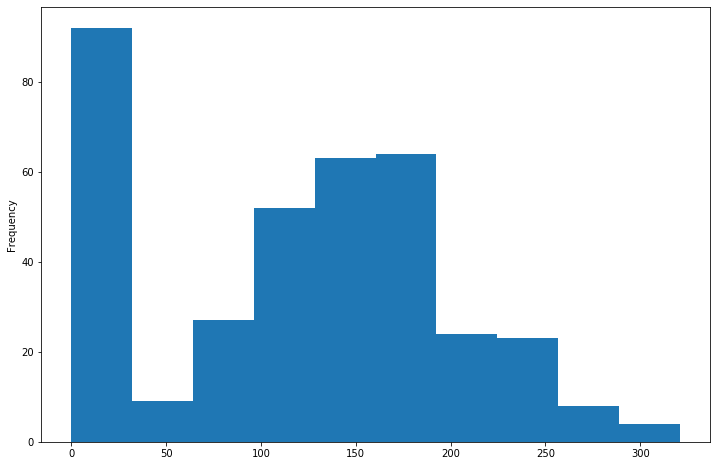

In [4]:
fig, axes = plt.subplots(figsize=(12, 8))
demand[1].plot.hist(ax=axes)


Create a class Product to store relevant product information

In [5]:
class Product:
    def __init__(self, i):
        self.i = i
        self.unit_cost = summary['Purchase Cost'].iloc[i - 1]
        self.lead_time = summary['Lead Time'].iloc[i - 1]
        self.size = summary['Size'].iloc[i - 1]
        self.selling_price = summary['Selling Price'].iloc[i - 1]
        self.holding_cost = summary['Ch'].iloc[i - 1]
        self.ordering_cost = summary['Co'].iloc[i - 1]
        self.probability = summary['Probability'].iloc[i - 1]
        self.starting_stock = summary['Starting Stock'].iloc[i - 1]
        self.demand_lead = summary['Demand_lead'].iloc[i - 1]
        self.mean = np.mean([np.log(j) for j in demand[demand[i] > 0][i]])
        self.sd = np.std([np.log(j) for j in demand[demand[i] > 0][i]])

Function to compute daily demand

In [6]:
def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

Function that computes Monte Carlo Simulation over the product and a hard coded review period

In [7]:
def monte_carlo(N, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability

    q = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % (review_period + lead_time) == 0:
            # Restocking day
            q = N - inventory
            data['orders'].append(q)
            inventory += q

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

Function to compute Profit 

In [8]:
def calculate_profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365
    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost
    profit = revenue - cost - Co - Ch
    return profit

Perform 1000 Monte Carlo Simulation with replenished stock amount as an input 

In [9]:
def mc_simulation(product, N, num_simulations=1000):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = monte_carlo(N, product)
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

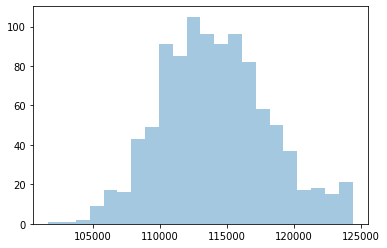

In [10]:
p_list, o_list = mc_simulation(Product(1), 3000, 1000)
sns.distplot(
    p_list,
    kde=False
)
plt.show()

### Find the optimum value 

### Periodic Review

In [11]:
product = Product(1)
def fn(args):
    M = args[0][0]
    
    p_list, o_list = mc_simulation(product, M, 500)
    
    print(f' M : {M}, Profit : ${np.mean(p_list):.2f}') 
    return -np.mean(p_list)

In [12]:
def periodic_review(product, low, high, step=50):
    m_range = [i for i in range(low, high, step)]
    review_dict = {}

    for M in m_range:
        p_list, o_list = mc_simulation(product, M)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

In [27]:
bounds = [{'name':'M', 'type':'discrete', 'domain': range(10,10000)}]

Op = BayesianOptimization(f = fn,
                         domain = bounds,
                         model_type = 'GP',
                         acquisition_type = 'EI',
                         exact_feval = False,
                         maximize = False,
                         normalize_Y = False)

Op.run_optimization(max_iter=100)

 M : 8002.0, Profit : $80105.71
 M : 682.0, Profit : $61538.75
 M : 7221.0, Profit : $97036.08
 M : 1006.0, Profit : $70814.66
 M : 283.0, Profit : $49885.11
 M : 683, Profit : $61574.88
 M : 7252, Profit : $96999.60
 M : 7262, Profit : $96730.12
 M : 4627, Profit : $127816.26
 M : 4366, Profit : $126167.58
 M : 4894, Profit : $129518.51
 M : 5060, Profit : $130241.57
 M : 5120, Profit : $130319.01
 M : 5138, Profit : $130148.93
 M : 5136, Profit : $130139.54
 M : 5135, Profit : $130638.81
 M : 5147, Profit : $130159.38
 M : 5144, Profit : $130324.29
 M : 5145, Profit : $130289.32
 M : 5145, Profit : $130047.97


In [28]:
Op.x_opt

array([5135.])